# Lesson 7: Build a Live Camera App

Rita Philavanh

20170905

## Retrieve Street View House Number (SVHN) training/test dataset

Download train.tar.gz and test.tar.gz files from http://ufldl.stanford.edu/housenumbers/ 

## Pre-processing

### Extract dataset from compressed tar.gz file

In [1]:
import os
import sys
import tarfile
import numpy as np

import time

In [2]:

num_classes = 0
np.random.seed(133)
data_root = '.'

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract('train.tar.gz')
test_folders = maybe_extract('test.tar.gz')

train already present - Skipping extraction of train.tar.gz.
[]
test already present - Skipping extraction of test.tar.gz.
[]


### Extract labels from .mat file 

(used digiStruct.py code found here: https://github.com/prijip/Py-Gsvhn-DigitStruct-Reader/blob/360a03909a22a28e2e814e83d6915ee5f915e5da/digitStruct.py)



In [3]:
import h5py
import numpy as np

#
# Bounding Box
#
class BBox:
    def __init__(self):
        self.label = ""     # Digit
        self.left = 0
        self.top = 0
        self.width = 0
        self.height = 0

class DigitStruct:
    def __init__(self):
        self.name = None    # Image file name
        self.bboxList = None # List of BBox structs

# Function for debugging
def printHDFObj(theObj, theObjName):
    isFile = isinstance(theObj, h5py.File)
    isGroup = isinstance(theObj, h5py.Group)
    isDataSet = isinstance(theObj, h5py.Dataset)
    isReference = isinstance(theObj, h5py.Reference)
    print("{}".format(theObjName))
    print("    type(): {}".format(type(theObj)))
    if isFile or isGroup or isDataSet:
        # if theObj.name != None:
        #    print "    name: {}".format(theObj.name)
        print("    id: {}".format(theObj.id))
    if isFile or isGroup:
        print("    keys: {}".format(theObj.keys()))
    if not isReference:
        print("    Len: {}".format(len(theObj)))

    if not (isFile or isGroup or isDataSet or isReference):
        print(theObj)

def readDigitStructGroup(dsFile):
    dsGroup = dsFile["digitStruct"]
    return dsGroup

#
# Reads a string from the file using its reference
#
def readString(strRef, dsFile):
    strObj = dsFile[strRef]
    str = ''.join(chr(i) for i in strObj)
    return str

#
# Reads an integer value from the file
#
def readInt(intArray, dsFile):
    intRef = intArray[0]
    isReference = isinstance(intRef, h5py.Reference)
    intVal = 0
    if isReference:
        intObj = dsFile[intRef]
        intVal = int(intObj[0])
    else: # Assuming value type
        intVal = int(intRef)
    return intVal

def yieldNextInt(intDataset, dsFile):
    for intData in intDataset:
        intVal = readInt(intData, dsFile)
        yield intVal 

def yieldNextBBox(bboxDataset, dsFile):
    for bboxArray in bboxDataset:
        bboxGroupRef = bboxArray[0]
        bboxGroup = dsFile[bboxGroupRef]
        labelDataset = bboxGroup["label"]
        leftDataset = bboxGroup["left"]
        topDataset = bboxGroup["top"]
        widthDataset = bboxGroup["width"]
        heightDataset = bboxGroup["height"]

        left = yieldNextInt(leftDataset, dsFile)
        top = yieldNextInt(topDataset, dsFile)
        width = yieldNextInt(widthDataset, dsFile)
        height = yieldNextInt(heightDataset, dsFile)

        bboxList = []

        for label in yieldNextInt(labelDataset, dsFile):
            bbox = BBox()
            bbox.label = label
            bbox.left = next(left)
            bbox.top = next(top)
            bbox.width = next(width)
            bbox.height = next(height)
            bboxList.append(bbox)

        yield bboxList

def yieldNextFileName(nameDataset, dsFile):
    for nameArray in nameDataset:
        nameRef = nameArray[0]
        name = readString(nameRef, dsFile)
        yield name

# dsFile = h5py.File('train/digitStruct.mat', 'r')
def yieldNextDigitStruct(dsFileName):
    dsFile = h5py.File(dsFileName, 'r')
    dsGroup = readDigitStructGroup(dsFile)
    nameDataset = dsGroup["name"]
    bboxDataset = dsGroup["bbox"]

    bboxListIter = yieldNextBBox(bboxDataset, dsFile)
    for name in yieldNextFileName(nameDataset, dsFile):
        bboxList = next(bboxListIter)
        obj = DigitStruct()
        obj.name = name
        obj.bboxList = bboxList
        yield obj

# Declare variables to store labels
L = []
y1 = []
y2 = []
y3 = []
y4 = []
y5 = []

#Declare variables to store overall bounding box
left = []
top = []
width = []
height = []

def testMain():
    i = 0
    dsFileName = 'train/digitStruct.mat'
    testCounter = 0

    for dsObj in yieldNextDigitStruct(dsFileName):
        # testCounter += 1
       # print(dsObj.name)
      #  print(len(dsObj.bboxList))
        L.append(len(dsObj.bboxList))
        
        cnty = 0
        width_sum = 0
        height_max = 0
        for bbox in dsObj.bboxList:
         #   print("    {}:{},{},{},{}".format(
         #       bbox.label, bbox.left, bbox.top, bbox.width, bbox.height))
            
            width_sum = width_sum + bbox.width
            height_max = max(height_max, bbox.height)
                
            if cnty == 0: 
                y1.append(bbox.label)
                left.append(bbox.left)
                top.append(bbox.top)
            elif cnty == 1: y2.append(bbox.label) 
            elif cnty == 2: y3.append(bbox.label)
            elif cnty == 3: y4.append(bbox.label)
            elif cnty == 4: y5.append(bbox.label)
            
            cnty += 1
            
        width.append(width_sum)
        height.append(height_max)

        # assign None to empty digits
        if cnty < 5:
            if len(dsObj.bboxList) < 1: y1.append(None)
            if len(dsObj.bboxList) < 2: y2.append(None) 
            if len(dsObj.bboxList) < 3: y3.append(None)
            if len(dsObj.bboxList) < 4: y4.append(None)
            if len(dsObj.bboxList) < 5: y5.append(None)
        if testCounter >= 5:
            break
        i +=1
        
if __name__ == "__main__":
    t1 = time.time()
    testMain()
    
    t2 = time.time()
    print("Time: %0.2fs" % (t2 - t1))

Time: 256.67s



### Check Labels

In [4]:
L = np.asarray(L)
y1 = np.asarray(y1)
y2 = np.asarray(y2)
y3 = np.asarray(y3)
y4 = np.asarray(y4)
y5 = np.asarray(y5)


if len(y3[y3==None]) != 0:
  print("convert")
# Convert 10 to actual 0 label
  y1[y1 == 10] = 0
  y2[y2 == 10] = 0
  y3[y3 == 10] = 0
  y4[y4 == 10] = 0
  y5[y5 == 10] = 0
# Replace None with 10 label
  y1[y1 == None] = 10
  y2[y2 == None] = 10
  y3[y3 == None] = 10
  y4[y4 == None] = 10
  y5[y5 == None] = 10
    

print(len(L))
print(L[40:50]) # length of digits
print(y1[40:50]) # 1st digit
print(y2[40:50]) # 2nd digit
print(y3[40:50]) # ...etc (If no digit, then 'None')
print(y4[40:50])
print(y5[40:50])

convert
33402
[2 3 2 3 2 3 2 2 3 3]
[4 2 2 2 1 3 2 4 8 1]
[2 5 9 0 0 2 4 6 1 0]
[10 1 10 4 10 7 10 10 7 3]
[10 10 10 10 10 10 10 10 10 10]
[10 10 10 10 10 10 10 10 10 10]


### Convert dataset to cropped 32x32 pixels grayscale matrix fitting outer bounding box

In [5]:
import cv2

t1 = time.time()

X = []
pic_num = 1
#print(len(os.listdir('./train')))
num_files = len([f for f in os.listdir('./train') if f.endswith('.png') and os.path.isfile(os.path.join('./train', f))])
for i in range(num_files): 
    #print(top[i], height[i], left[i], width[i])
    img = cv2.imread("./train/"+str(pic_num) +".png",cv2.IMREAD_GRAYSCALE)
    #print(img.shape)
    #print(img[top[i]:(top[i]+height[i]), left[i]:(left[i]+width[i])].shape)
    crop_img = img[max(0,top[i]):(max(0,top[i])+max(0,height[i])), max(0,left[i]):(max(0,left[i])+max(0,width[i]))]
    resized_image = cv2.resize(crop_img, (32, 32))
    X.append(resized_image)
   # print(pic_num)
    pic_num +=1

t2 = time.time()
print("Time: %0.2fs" % (t2 - t1))

Time: 459.72s


### Split dataset into train and validation set

In [6]:
X_train = X[:20000]
L_train = L[:20000] 

y1_train = y1[:20000]
y2_train = y2[:20000]
y3_train = y3[:20000]
y4_train = y4[:20000]
y5_train = y5[:20000]

X_valid = X[20000:]
L_valid = L[20000:] 
y1_valid = y1[20000:]
y2_valid = y2[20000:]
y3_valid = y3[20000:]
y4_valid = y4[20000:]
y5_valid = y5[20000:]

print(len(X), len(X_valid), len(X_train))
print(len(L), len(L_valid), len(L_train))

33402 13402 20000
33402 13402 20000


### Reformat data dimensions

In [7]:
image_size = 32 # 32 x 32 pixel
num_channels = 1 # grayscale
num_labels = 11 # 0-9 + 10 (for missing value)
num_digits = 6 #max 5 digit for housenumber

import numpy as np

def reformat(dataset, label0, label1, label2, label3, label4, label5):
  dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
  print((label0[:10]))
  print((label1[:10]))
  print((label2[:10]))
  print((label3[:10]))
  print(label3[:10])
  label0 = (np.arange(num_digits) == label0[:,None]).astype(np.float32)
  label1 = (np.arange(num_labels) == label1[:,None]).astype(np.float32)
  label2 = (np.arange(num_labels) == label2[:,None]).astype(np.float32)
  label3 = (np.arange(num_labels) == label3[:,None]).astype(np.float32)
  label4 = (np.arange(num_labels) == label4[:,None]).astype(np.float32)
  label5 = (np.arange(num_labels) == label5[:,None]).astype(np.float32)

  print(label3[:10])
  return dataset, label0, label1, label2, label3, label4, label5
train_dataset, train_label0, train_label1, train_label2, train_label3, train_label4, train_label5 = reformat(np.asarray(X_train), L_train, y1_train, y2_train, y3_train, y4_train, y5_train)
valid_dataset, valid_label0, valid_label1, valid_label2, valid_label3, valid_label4, valid_label5 = reformat(np.asarray(X_valid), L_valid, y1_valid, y2_valid, y3_valid, y4_valid, y5_valid)
#test_dataset, test_labels = reformat(test_dataset, test_labels)

#normalize to 0 mean and unit variance
train_dataset_norm = (train_dataset - np.mean( train_dataset))/np.std( train_dataset)

# Check values
print('Training set', train_dataset.shape, train_label0.shape, train_label1.shape)
print('Validation set', valid_dataset.shape, valid_label0.shape, valid_label1.shape)
#print('Test set', test_dataset.shape, test_labels.shape)

[2 2 2 2 2 2 2 3 3 2]
[1 2 2 9 3 3 2 7 1 1]
[9 3 5 3 1 3 8 4 2 6]
[10 10 10 10 10 10 10 4 8 10]
[10 10 10 10 10 10 10 4 8 10]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
[3 1 2 3 3 3 3 2 3 3]
[1 7 5 1 2 6 1 4 7 1]
[3 10 0 6 6 9 3 1 5 2]
[6 10 10 9 7 6 5 10 1 4]
[6 10 10 9 7 6 5 10 1 4]
[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0

## Plot house number image

#### Reference: https://github.com/llSourcell/How_to_make_a_tensorflow_image_classifier_LIVE/blob/master/demonotes.ipynb

['19', '23', '25', '93', '31', '33', '28', '744', '128']


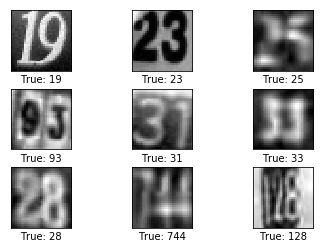

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_images(images, cls_true, cls_pred=None):
    #assert len(images) == len(cls_true) 
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(image_size, image_size), cmap='binary')
        
        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
# Get the first images from the test-set.
images = train_dataset_norm[0:9]
    
# Get the true classes for those images.
cls_true = ["{}{}{}{}{}".format(str(a_).replace('10',''), str(b_).replace('10',''), str(c_).replace('10',''), str(d_).replace('10',''), str(e_).replace('10','')) 
       for a_, b_, c_, d_, e_ in zip(y1_train[0:9], y2_train[0:9], y3_train[0:9], y4_train[0:9], y5_train[0:9])]

print(["{}{}{}{}{}".format(str(a_).replace('10',''), str(b_).replace('10',''), str(c_).replace('10',''), str(d_).replace('10',''), str(e_).replace('10','')) 
       for a_, b_, c_, d_, e_ in zip(y1_train[0:9], y2_train[0:9], y3_train[0:9], y4_train[0:9], y5_train[0:9])])
# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

# Import Modules 

In [9]:
import tensorflow as tf
import numpy as np

# Neural Network Configurations

In [158]:
batch_size = 256
valid_dataset_batch = valid_dataset[:batch_size]

num_conv_layers = 3
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

#Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36        # There are 36 of these filters.

#Convolutional Layer 2.
filter_size3 = 5          # Convolution filters are 5 x 5 pixels.
num_filters3 = 64        # There are 64 of these filters.

# Fully-connected layer.
fc_size = 1024         # Number of neurons in fully-connected hidden layer
num_fc_layers = 3
drop_rate1 = 0.4 
drop_rate2 = 0.8

# Create graph

### Declare variables to initialize

In [159]:
graph = tf.Graph()

with graph.as_default():
    #with tf.device('/gpu:0'):
    
  def weight_variable(w_id, shape, stdev_num):
    #return (tf.Variable(tf.truncated_normal(shape,stddev=np.sqrt(2.0/(stdev_num)))))
    return (tf.get_variable(w_id,  initializer = tf.truncated_normal(shape,stddev=np.sqrt(2.0/(stdev_num)))))

  def bias_variable(b_id, shape):
    initial = tf.constant(0.1, shape=shape)
    #return tf.Variable(initial)
    return tf.get_variable(b_id, initializer = initial)

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels0 = tf.placeholder(tf.float32, shape=(batch_size, num_digits))
  tf_train_labels1 = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_train_labels2 = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_train_labels3 = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_train_labels4 = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_train_labels5 = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset =  tf.constant(valid_dataset_batch) 
 # tf_test_dataset = tf.constant(test_dataset) 

  def conv_layers(layer_num, data, weights, biases, input_size,filter_size, num_filters, valid=False, use_pooling=True): 
   # ########
   # # Conv with leaky relu and 2x2 max pooling
   # ########

    if not valid:
    # create filter-weights and bias during training
        shape = [filter_size, filter_size, input_size, num_filters]
        stdev_n = (filter_size*filter_size*input_size)
        weights.append(weight_variable("cvw0_"+layer_num, shape, stdev_n))
        biases.append(bias_variable("cvb0_"+layer_num, [num_filters]))

    hidden=[]
    y0 =  tf.nn.conv2d(input=data,filter=weights[0],strides=[1, 1, 1, 1],padding='SAME')
    hidden.append(tf.maximum((y0 + biases[0]), 0.01*(y0+biases[0])))
    
    for L in range(1,num_conv_layers+1):   
        if not valid:
            shape = [filter_size, filter_size, num_filters, num_filters]
            stdev_n = filter_size*filter_size*num_filters
                
            weights.append(weight_variable("cvw"+str(L)+"_"+layer_num, shape, stdev_n))
            biases.append(bias_variable("cvb"+str(L)+"_"+layer_num, [num_filters]))   

        y = tf.nn.conv2d(input=hidden[L-1],filter=weights[L],strides=[1, 1, 1, 1],padding='SAME')
        hidden.append(tf.maximum((y + biases[L]), 0.01*(y+biases[L])))

    layer = tf.nn.max_pool(value=hidden[num_conv_layers], ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    return layer, weights, biases
    
  def fc_layers(layer_num, weights, biases, out_weights, out_biases, data, label_count, valid = False):
   #  #####
   #  # FC Layers - with leaky relu and dropout
   #  #####

    out_size = data.get_shape().as_list()[1]
    if not valid:
        #create weights and biases during training
        weights.append(weight_variable("fcw0_"+layer_num, [out_size, fc_size], fc_size*fc_size)) # w = 1024 depth * 1024 FC hidden node layer
        biases.append(bias_variable("fcb0_"+layer_num, [fc_size])) #  # b = 1024 FC hidden node layers1024

    hidden=[]
    y0 = (tf.matmul(data, weights[0]) + biases[0])
    hidden.append(tf.nn.dropout(tf.maximum(y0, 0.01*y0), drop_rate1))
    
    for L in range(1,num_fc_layers+1):   
        if not valid:
            weights.append(weight_variable("fcw"+str(L)+"_"+layer_num,[fc_size, fc_size], fc_size*fc_size))
            biases.append(bias_variable("fcb"+str(L)+"_"+layer_num,[fc_size]))   
        y = ((tf.matmul(hidden[L-1], weights[L]) + biases[L])) 
        hidden.append(tf.nn.dropout(tf.maximum(y, 0.01*y), drop_rate2))
        
      #Definitive output  after relu layer's:  
    if not valid:
        out_weights = weight_variable("rlw_"+layer_num,[fc_size, label_count], fc_size*label_count)
        out_biases = bias_variable("rlb_"+layer_num,[label_count])      
    logits = tf.matmul(hidden[num_fc_layers], out_weights) + out_biases
        
    return logits, weights, biases, out_weights, out_biases
    
  wc1, wc2, wc3 = [], [], []
  bc1, bc2, bc3 = [], [], []
  convpool1, wc1, bc1 = conv_layers("1", tf_train_dataset, wc1, bc1, num_channels, filter_size1, num_filters1)
  convpool2, wc2, bc2 = conv_layers("2", convpool1, wc2, bc2, num_filters1, filter_size2, num_filters2)
  convpool3, wc3, bc3 = conv_layers("3", convpool2, wc3, bc3, num_filters2, filter_size3, num_filters3)

  shape = convpool3.get_shape().as_list()
  conv_layers_reshape = tf.reshape(convpool3, [shape[0], shape[1] * shape[2] * shape[3]]) #[256, 4, 4, 64]

  w0, w1, w2, w3, w4, w5 = [], [], [], [], [], []
  b0, b1, b2, b3, b4, b5 = [], [], [], [], [], []
  
 # Training computation.
  logits0, w0, b0, out_w0, out_b0 = fc_layers("1", w0, b0, None, None, conv_layers_reshape, num_digits)  
  logits1, w1, b1, out_w1, out_b1 = fc_layers("2", w1, b1, None, None, conv_layers_reshape, num_labels) 
  logits2, w2, b2, out_w2, out_b2 = fc_layers("3", w2, b2, None, None, conv_layers_reshape, num_labels) 
  logits3, w3, b3, out_w3, out_b3 = fc_layers("4", w3, b3, None, None, conv_layers_reshape, num_labels) 
  logits4, w4, b4, out_w4, out_b4 = fc_layers("5", w4, b4, None, None, conv_layers_reshape, num_labels) 
  logits5, w5, b5, out_w5, out_b5 = fc_layers("6", w5, b5, None, None, conv_layers_reshape, num_labels)   

  loss0 = tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels0, logits=logits0) 
  loss1 = tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels1, logits=logits1)
  loss2 = tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels2, logits=logits2)
  loss3 = tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels3, logits=logits3)
  loss4 = tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels4, logits=logits4)
  loss5 = tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels5, logits=logits5)
  loss= tf.reduce_mean(loss0) + tf.reduce_mean(loss1) + tf.reduce_mean(loss2) + tf.reduce_mean(loss3) + tf.reduce_mean(loss4) + tf.reduce_mean(loss5)
    
 # Optimizer.
 # optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  global_step = tf.Variable(0) #, trainable=False)  # count the number of steps taken.
 # learning_rate = tf.train.exponential_decay(0.1, global_step, 100000, 0.96, staircase=True)
#  learning_rate = tf.train.exponential_decay(0.05, global_step, 100, 0.95) #, staircase=True)
 # optimizer = tf.train.GradientDescentOptimizer(1e-6).minimize(loss) #, global_step=global_step)
  optimizer =tf.train.AdamOptimizer(0.001).minimize(loss, global_step=global_step) 

  # Validation computation.
  convpool1v, _, _ = conv_layers("1", tf_valid_dataset, wc1, bc1, num_channels, filter_size1, num_filters1, True)
  convpool2v, _, _ = conv_layers("2", convpool1v, wc2, bc2, num_filters1, filter_size2, num_filters2, True)
  convpool3v, _, _ = conv_layers("3", convpool2v, wc3, bc3, num_filters2, filter_size3, num_filters3, True)
  shapev = convpool3v.get_shape().as_list()
  conv_layers_reshape_valid = tf.reshape(convpool3v, [shapev[0], shapev[1] * shapev[2] * shapev[3]]) #[256, 4, 4, 64]

  logits0_valid, _, _, _, _ = fc_layers("1", w0, b0, out_w0, out_b0, conv_layers_reshape_valid, num_digits, True) 
  logits1_valid, _, _, _, _ = fc_layers("2", w1, b1, out_w1, out_b1, conv_layers_reshape_valid, num_labels, True) 
  logits2_valid, _, _, _, _ = fc_layers("3", w2, b2, out_w2, out_b2, conv_layers_reshape_valid, num_labels, True) 
  logits3_valid, _, _, _, _ = fc_layers("4", w3, b3, out_w3, out_b3, conv_layers_reshape_valid, num_labels, True) 
  logits4_valid, _, _, _, _ = fc_layers("5", w4, b4, out_w4, out_b4, conv_layers_reshape_valid, num_labels, True) 
  logits5_valid, _, _, _, _ = fc_layers("6", w5, b5, out_w5, out_b5, conv_layers_reshape_valid, num_labels, True) 

 # Predictions for the training, validation, and test data.
  train_prediction0 = tf.nn.softmax(logits0)
  valid_prediction0 = tf.nn.softmax(logits0_valid)
  train_prediction1 = tf.nn.softmax(logits1)
  valid_prediction1 = tf.nn.softmax(logits1_valid)
  train_prediction2 = tf.nn.softmax(logits2)
  valid_prediction2 = tf.nn.softmax(logits2_valid)
  train_prediction3 = tf.nn.softmax(logits3)
  valid_prediction3 = tf.nn.softmax(logits3_valid)
  train_prediction4 = tf.nn.softmax(logits4)
  valid_prediction4 = tf.nn.softmax(logits4_valid)
  train_prediction5 = tf.nn.softmax(logits5)
  valid_prediction5 = tf.nn.softmax(logits5_valid)

  #test_prediction = tf.nn.softmax(model(tf_test_dataset)) 

  # Add ops to save and restore all the variables.
  saver = tf.train.Saver()

### Run graph session

In [160]:
import time

t1 = time.time()

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

#def eval_accuracy(eval_l_preds, eval_preds, l_labels, labels, masks):
#    concatted = np.concatenate((np.reshape((eval_l_preds == l_labels), [-1, 1]), 
#                                (eval_preds * masks) == labels), axis=1)
#    return 100.0 * (np.sum([np.all(row) for row in concatted])) / len(labels)
#

num_steps = 3001
max_acc = 0
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run() # sess.run(tf.global_variables_initializer())
  #session.run(init_op)
  print('Initialized')
    
  for step in range(num_steps):
    offset = (step * batch_size) % (np.asarray(y1_train).shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :] #, :, :]
    
    #normalize data to mean 0 and unit variance
   # batch_data = (batch_data - np.mean(batch_data))/np.std(batch_data)
    #batch_data = np.reshape(batch_data,(batch_size,image_size*image_size))
   # print(batch_data.shape)

  #  batch_data_valid = valid_dataset[offset:(offset + batch_size), :] #, :, :]

    batch_labels0 =  np.asarray(train_label0)[offset:(offset + batch_size), :]
    batch_labels1 =  np.asarray(train_label1)[offset:(offset + batch_size), :]
    batch_labels2 =  np.asarray(train_label2)[offset:(offset + batch_size), :]
    batch_labels3 =  np.asarray(train_label3)[offset:(offset + batch_size), :]
    batch_labels4 =  np.asarray(train_label4)[offset:(offset + batch_size), :]
    batch_labels5 =  np.asarray(train_label5)[offset:(offset + batch_size), :]    
   # print(batch_labels1.shape)
    feed_dict = {tf_train_dataset : batch_data
              #  , tf_valid_dataset : batch_data_valid
                , tf_train_labels0 : batch_labels0
                , tf_train_labels1 : batch_labels1
                , tf_train_labels2 : batch_labels2
                , tf_train_labels3 : batch_labels3
                , tf_train_labels4 : batch_labels4
                , tf_train_labels5 : batch_labels5
                }

    _, l, pred_train0, pred_train1, pred_train2, pred_train3, pred_train4, pred_train5  \
        , pred_valid0, pred_valid1, pred_valid2, pred_valid3, pred_valid4, pred_valid5  \
        = session.run([optimizer, loss, train_prediction0, train_prediction1, train_prediction2  \
                       , train_prediction3, train_prediction4, train_prediction5, valid_prediction0  \
                       , valid_prediction1, valid_prediction2, valid_prediction3 , valid_prediction4, valid_prediction5]  \
                      , feed_dict=feed_dict)
     
    #normalize data to mean 0 and unit variance
  #  batch_data = (batch_data - np.mean(batch_data))/np.std(batch_data)
    #batch_data = np.reshape(batch_data,(batch_size,image_size*image_size))
   # print(batch_data.shape)
   # batch_valid_labels0 =  np.asarray(valid_label0)[offset:(offset + batch_size), :]
   # batch_valid_labels1 =  np.asarray(valid_label1)[offset:(offset + batch_size), :]
   # batch_valid_labels2 =  np.asarray(valid_label2)[offset:(offset + batch_size), :]
   # batch_valid_labels3 =  np.asarray(valid_label3)[offset:(offset + batch_size), :]
   # batch_valid_labels4 =  np.asarray(valid_label4)[offset:(offset + batch_size), :]
   # batch_valid_labels5 =  np.asarray(valid_label5)[offset:(offset + batch_size), :]  
    
    if (step % 50 == 0):
      print('Minibatch training loss at step %d: %f' % (step, l))
      print("Training accuracy - digit count: {:.1f}%; digits 1-5: {:.1f}%, {:.1f}%, {:.1f}%, {:.1f}%, {:.1f}%".format( \
           accuracy(pred_train0, batch_labels0),accuracy(pred_train1, batch_labels1)  \
        ,accuracy(pred_train2, batch_labels2), accuracy(pred_train3, batch_labels3)  \
        ,accuracy(pred_train4, batch_labels4), accuracy(pred_train5, batch_labels5)))
        
      avg_acc_train = (accuracy(pred_train0, batch_labels0) + accuracy(pred_train1, batch_labels1)
        + accuracy(pred_train2, batch_labels2) + accuracy(pred_train3, batch_labels3)
        + accuracy(pred_train4, batch_labels4) + accuracy(pred_train5, batch_labels5))/6
      print('Training avg accuracy: %.1f%%' % avg_acc_train)
        
      print("Validation accuracy - digit count: {:.1f}%; digits 1-5: {:.1f}%, {:.1f}%, {:.1f}%, {:.1f}%, {:.1f}%".format( \
           accuracy(pred_valid0, valid_label0[:batch_size]),accuracy(pred_valid1, valid_label1[:batch_size])  \
        ,accuracy(pred_valid2, valid_label2[:batch_size]), accuracy(pred_valid3, valid_label3[:batch_size])  \
        ,accuracy(pred_valid4, valid_label4[:batch_size]), accuracy(pred_valid5, valid_label5[:batch_size])))
    
      avg_acc_valid = (accuracy(pred_valid0, valid_label0[:batch_size]) + accuracy(pred_valid1, valid_label1[:batch_size])
        + accuracy(pred_valid2, valid_label2[:batch_size]) + accuracy(pred_valid3, valid_label3[:batch_size])
        + accuracy(pred_valid4, valid_label4[:batch_size]) + accuracy(pred_valid5, valid_label5[:batch_size]))/6
      print('Validation avg accuracy: %.1f%%' % avg_acc_valid)
    
    if avg_acc_valid > max_acc:
        max_acc = avg_acc_valid
        # Save the variables to disk.
        save_path = saver.save(session, "C:/Users/rphila/Documents/Online Courses/DeepLearning/model/model.ckpt")
        print("Model saved in file: %s" % save_path)
    
    # print("w1 mean: {} std: {}".format(np.mean(w), np.std(w)))
     # print("wy1 mean: {} std: {}".format(np.mean(w1), np.std(w1)))
      #print("label: ", batch_labels1)
    #  print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), L_valid))
  #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

t2 = time.time()

print("Time: %0.2fs" % (t2 - t1))

Initialized
Minibatch training loss at step 0: 13.777848
Training accuracy - digit count: 3.1%; digits 1-5: 6.6%, 6.2%, 4.3%, 2.0%, 2.0%
Training avg accuracy: 4.0%
Validation accuracy - digit count: 3.1%; digits 1-5: 11.3%, 8.6%, 4.7%, 2.0%, 1.6%
Validation avg accuracy: 5.2%
Model saved in file: C:/Users/rphila/Documents/Online Courses/DeepLearning/model/model.ckpt
Minibatch training loss at step 50: 7.124750
Training accuracy - digit count: 49.6%; digits 1-5: 25.0%, 19.1%, 68.8%, 96.9%, 100.0%
Training avg accuracy: 59.9%
Validation accuracy - digit count: 48.8%; digits 1-5: 27.3%, 18.4%, 67.2%, 96.1%, 100.0%
Validation avg accuracy: 59.6%
Model saved in file: C:/Users/rphila/Documents/Online Courses/DeepLearning/model/model.ckpt
Minibatch training loss at step 100: 6.987835
Training accuracy - digit count: 53.9%; digits 1-5: 27.7%, 19.1%, 73.0%, 96.1%, 100.0%
Training avg accuracy: 61.7%
Validation accuracy - digit count: 48.8%; digits 1-5: 27.3%, 18.4%, 67.2%, 96.1%, 100.0%
Valida

Model saved in file: C:/Users/rphila/Documents/Online Courses/DeepLearning/model/model.ckpt
Minibatch training loss at step 1200: 1.618898
Training accuracy - digit count: 97.3%; digits 1-5: 93.0%, 81.6%, 80.1%, 94.5%, 100.0%
Training avg accuracy: 91.1%
Validation accuracy - digit count: 91.8%; digits 1-5: 85.2%, 79.3%, 74.2%, 96.1%, 100.0%
Validation avg accuracy: 87.8%
Minibatch training loss at step 1250: 1.384715
Training accuracy - digit count: 98.0%; digits 1-5: 92.2%, 87.9%, 82.8%, 96.5%, 99.6%
Training avg accuracy: 92.8%
Validation accuracy - digit count: 93.4%; digits 1-5: 87.9%, 78.5%, 73.4%, 96.5%, 100.0%
Validation avg accuracy: 88.3%
Minibatch training loss at step 1300: 1.507797
Training accuracy - digit count: 96.1%; digits 1-5: 94.5%, 87.9%, 78.9%, 96.1%, 100.0%
Training avg accuracy: 92.3%
Validation accuracy - digit count: 91.8%; digits 1-5: 87.9%, 78.5%, 72.3%, 94.5%, 100.0%
Validation avg accuracy: 87.5%
Minibatch training loss at step 1350: 1.628713
Training accu

Model saved in file: C:/Users/rphila/Documents/Online Courses/DeepLearning/model/model.ckpt
Minibatch training loss at step 2600: 0.752590
Training accuracy - digit count: 99.2%; digits 1-5: 96.5%, 89.5%, 93.0%, 97.7%, 100.0%
Training avg accuracy: 96.0%
Validation accuracy - digit count: 89.5%; digits 1-5: 83.6%, 77.7%, 81.2%, 95.7%, 100.0%
Validation avg accuracy: 88.0%
Minibatch training loss at step 2650: 0.811610
Training accuracy - digit count: 98.8%; digits 1-5: 94.9%, 92.6%, 93.4%, 96.1%, 100.0%
Training avg accuracy: 96.0%
Validation accuracy - digit count: 90.6%; digits 1-5: 85.2%, 81.2%, 80.5%, 95.3%, 100.0%
Validation avg accuracy: 88.8%
Minibatch training loss at step 2700: 0.842172
Training accuracy - digit count: 98.8%; digits 1-5: 96.1%, 89.5%, 90.2%, 97.3%, 100.0%
Training avg accuracy: 95.3%
Validation accuracy - digit count: 91.4%; digits 1-5: 84.8%, 80.1%, 80.9%, 96.1%, 100.0%
Validation avg accuracy: 88.9%
Minibatch training loss at step 2750: 0.670006
Training acc

# Restore model to predict on test data
## Create graph for test data

In [161]:
#batch_size=1
#graph = tf.Graph()

with graph.as_default():
    #with tf.device('/gpu:0'):
    
  def weight_variable(w_id, shape, stdev_num):
    #return (tf.Variable(tf.truncated_normal(shape,stddev=np.sqrt(2.0/(stdev_num)))))
    return (tf.get_variable(w_id,  initializer = tf.truncated_normal(shape,stddev=np.sqrt(2.0/(stdev_num)))))

  def bias_variable(b_id, shape):
    initial = tf.constant(0.1, shape=shape)
    #return tf.Variable(initial)
    return tf.get_variable(b_id, initializer = initial)
    
  tf_test_dataset = tf.placeholder(tf.float32, shape=[1, image_size, image_size, 1]) 

  def conv_layers(layer_num, data, weights, biases, input_size,filter_size, num_filters, valid=False, use_pooling=True): 
   # ########
   # # Conv with leaky relu and 2x2 max pooling
   # ########

    if not valid:
    # create filter-weights and bias during training
        shape = [filter_size, filter_size, input_size, num_filters]
        stdev_n = (filter_size*filter_size*input_size)
        weights.append(weight_variable("cvw0_"+layer_num, shape, stdev_n))
        biases.append(bias_variable("cvb0_"+layer_num, [num_filters]))

    hidden=[]
    y0 =  tf.nn.conv2d(input=data,filter=weights[0],strides=[1, 1, 1, 1],padding='SAME')
    hidden.append(tf.maximum((y0 + biases[0]), 0.01*(y0+biases[0])))
    
    for L in range(1,num_conv_layers+1):   
        if not valid:
            shape = [filter_size, filter_size, num_filters, num_filters]
            stdev_n = filter_size*filter_size*num_filters
                
            weights.append(weight_variable("cvw"+str(L)+"_"+layer_num, shape, stdev_n))
            biases.append(bias_variable("cvb"+str(L)+"_"+layer_num, [num_filters]))   

        y = tf.nn.conv2d(input=hidden[L-1],filter=weights[L],strides=[1, 1, 1, 1],padding='SAME')
        hidden.append(tf.maximum((y + biases[L]), 0.01*(y+biases[L])))

    layer = tf.nn.max_pool(value=hidden[num_conv_layers], ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    return layer, weights, biases
    
  def fc_layers(layer_num, weights, biases, out_weights, out_biases, data, label_count, valid = False):
   #  #####
   #  # FC Layers - with leaky relu and dropout
   #  #####

    out_size = data.get_shape().as_list()[1]
    if not valid:
        #create weights and biases during training
        weights.append(weight_variable("fcw0_"+layer_num, [out_size, fc_size], fc_size*fc_size)) # w = 1024 depth * 1024 FC hidden node layer
        biases.append(bias_variable("fcb0_"+layer_num, [fc_size])) #  # b = 1024 FC hidden node layers1024

    hidden=[]
    y0 = (tf.matmul(data, weights[0]) + biases[0])
    hidden.append(tf.nn.dropout(tf.maximum(y0, 0.01*y0), drop_rate1))
    
    for L in range(1,num_fc_layers+1):   
        if not valid:
            weights.append(weight_variable("fcw"+str(L)+"_"+layer_num,[fc_size, fc_size], fc_size*fc_size))
            biases.append(bias_variable("fcb"+str(L)+"_"+layer_num,[fc_size]))   
        y = ((tf.matmul(hidden[L-1], weights[L]) + biases[L])) 
        hidden.append(tf.nn.dropout(tf.maximum(y, 0.01*y), drop_rate2))
        
      #Definitive output  after relu layer's:  
    if not valid:
        out_weights = weight_variable("rlw_"+layer_num,[fc_size, label_count], fc_size*label_count)
        out_biases = bias_variable("rlb_"+layer_num,[label_count])      
    logits = tf.matmul(hidden[num_fc_layers], out_weights) + out_biases
        
    return logits, weights, biases, out_weights, out_biases
    
  
  # Test data computation.
  convpool1v, _, _ = conv_layers("1", tf_test_dataset, wc1, bc1, num_channels, filter_size1, num_filters1, True)
  convpool2v, _, _ = conv_layers("2", convpool1v, wc2, bc2, num_filters1, filter_size2, num_filters2, True)
  convpool3v, _, _ = conv_layers("3", convpool2v, wc3, bc3, num_filters2, filter_size3, num_filters3, True)
  shapev = convpool3v.get_shape().as_list()
  conv_layers_reshape_valid = tf.reshape(convpool3v, [shapev[0], shapev[1] * shapev[2] * shapev[3]]) #[256, 4, 4, 64]

  logits0_test, _, _, _, _ = fc_layers("1", w0, b0, out_w0, out_b0, conv_layers_reshape_valid, num_digits, True) 
  logits1_test, _, _, _, _ = fc_layers("2", w1, b1, out_w1, out_b1, conv_layers_reshape_valid, num_labels, True) 
  logits2_test, _, _, _, _ = fc_layers("3", w2, b2, out_w2, out_b2, conv_layers_reshape_valid, num_labels, True) 
  logits3_test, _, _, _, _ = fc_layers("4", w3, b3, out_w3, out_b3, conv_layers_reshape_valid, num_labels, True) 
  logits4_test, _, _, _, _ = fc_layers("5", w4, b4, out_w4, out_b4, conv_layers_reshape_valid, num_labels, True) 
  logits5_test, _, _, _, _ = fc_layers("6", w5, b5, out_w5, out_b5, conv_layers_reshape_valid, num_labels, True) 

 # Predictions test data.
  test_prediction0 = tf.nn.softmax(logits0_test)
  test_prediction1 = tf.nn.softmax(logits1_test)
  test_prediction2 = tf.nn.softmax(logits2_test)
  test_prediction3 = tf.nn.softmax(logits3_test)
  test_prediction4 = tf.nn.softmax(logits4_test)
  test_prediction5 = tf.nn.softmax(logits5_test)



In [166]:
#tf.reset_default_graph()

test_data = valid_dataset[[2]]
print(test_data.shape)

with tf.Session(graph=graph) as session:
  saver.restore(session, "C:/Users/rphila/Documents/Online Courses/DeepLearning/model/model.ckpt")
  print("Model restored.")

  feed_dict = {tf_test_dataset : test_data}
                 
  pred0, pred1, pred2, pred3, pred4, pred5  \
        = session.run([test_prediction0, test_prediction1, test_prediction2, test_prediction3
                       , test_prediction4, test_prediction5] , feed_dict=feed_dict)

  pred = []
  pred.append(pred1[0].tolist().index(max(pred1[0])))
  pred.append(pred2[0].tolist().index(max(pred2[0])))
  pred.append(pred3[0].tolist().index(max(pred3[0])))
  pred.append(pred4[0].tolist().index(max(pred4[0])))
  pred.append(pred5[0].tolist().index(max(pred5[0])))
  print(pred)
  predict_lbl =''
  for i in range(0, pred0[0].tolist().index(max(pred0[0]))):
    predict_lbl = predict_lbl + str(pred[i])
    
  print(predict_lbl)

(1, 32, 32, 1)
INFO:tensorflow:Restoring parameters from C:/Users/rphila/Documents/Online Courses/DeepLearning/model/model.ckpt
Model restored.
[5, 0, 10, 10, 10]
50


IndexError: index 1 is out of bounds for axis 0 with size 1

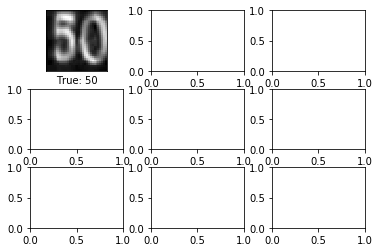

In [167]:
plot_images(images=test_data, cls_true=[predict_lbl])